KOSPI Stochastic Volatility Prediction 

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data=pd.read_csv('./data/kospi_daily.csv',index_col=0, parse_dates=True)
returns=data['Close'].pct_change().dropna()*100

In [14]:
# Log Chi-Square Approximation Parameters
# Stochastic volatility with leverage: fast and efficient likelihood inference paper's Table 1
# https://www.economics.uci.edu/files/docs/colloqpapers/w06/chib.pdf
LOG_CHI_SQ_APPROX_PARAMS={
    'p':[0.00609, 0.04775, 0.13057, 0.20674, 0.22715, 0.18842, 0.12047, 0.05591, 0.01575, 0.00115],
    'mean':[1.92677, 1.34744, 0.73504, 0.02266, -0.85173, -1.97278, -3.46788, -5.55246, -8.68384, -14.65000],
    'var':[0.11265, 0.17788, 0.26768, 0.40611, 0.62699, 0.98583, 1.57469, 2.54498, 4.16591, 7.33342]
}

Sampling Functions

In [15]:
from numpy.linalg import cholesky
from numba import njit

def sample_mu_phi(latent_volatility:np.ndarray, parameter_dict:dict, sigma2_eta:float, mu_prev:float, phi_prev:float)->np.ndarray:
    T=len(latent_volatility)
    h=latent_volatility
    z=np.vstack((np.ones(T-1), h[:-1])).T # (T-1,2)
    y=h[1:] # (T-1,)

    mu_phi_mean_prior=parameter_dict['mu_phi_mean']
    mu_phi_var_prior=parameter_dict['mu_phi_cov']

    mu_phi_var_post=np.linalg.inv(np.linalg.inv(mu_phi_var_prior)+np.dot(z.T,z)/sigma2_eta)
    mu_phi_mean_post= mu_phi_var_post @ (np.linalg.inv(mu_phi_var_prior) @ mu_phi_mean_prior + np.dot(z.T,y)/sigma2_eta)
    
    L=cholesky(mu_phi_var_post)
    mu_phi_sample=mu_phi_mean_post + L @ np.random.normal(size=2)
    mu, sampled_phi=mu_phi_sample
    if sampled_phi<=-1 or sampled_phi>=1:
        return mu_prev, phi_prev
    return mu, sampled_phi

def sample_sigma2_eta(latent_volatility:np.ndarray, parameter_dict:dict, mu:float, phi:float, rng=None)->float:
    if rng is None:
        rng = np.random.default_rng()
    T=len(latent_volatility)
    h=latent_volatility
    residuals=h[1:] - mu - phi*(h[:-1])
    alpha_prior=parameter_dict['sigma2_shape']
    beta_prior=parameter_dict['sigma2_scale']
    alpha_post=(alpha_prior + (T-1))/2
    beta_post=(beta_prior + np.sum(residuals**2))/2
    inv_sampled_sigma2_eta=rng.gamma(shape=alpha_post, scale=1.0/beta_post)
    return 1.0/inv_sampled_sigma2_eta

def sample_states(latent_volatility:np.ndarray, returns_log_sq:np.ndarray)->np.ndarray:
    T=len(latent_volatility)
    h=latent_volatility
    yls=returns_log_sq

    p=np.array(LOG_CHI_SQ_APPROX_PARAMS['p']) # (m, )
    mu_k=np.array(LOG_CHI_SQ_APPROX_PARAMS['mean']) # (m, )
    var_k=np.array(LOG_CHI_SQ_APPROX_PARAMS['var']) # (m, )

    y_center=yls[:, None]-(h[:, None]+mu_k[None, :]) # (T, m)
    log_prob=np.log(p[None, :]) - 0.5*np.log(2*np.pi*var_k[None, :]) - 0.5*(y_center**2)/var_k[None, :] # (T, m)

    # row-wise softmax
    log_max=np.max(log_prob, axis=1, keepdims=True) # (T, 1)
    w=np.exp(log_prob - log_max) # (T, m)
    prob=w/np.sum(w, axis=1, keepdims=True) # (T, m)

    u=np.random.rand(T, 1)
    cdf=np.cumsum(prob, axis=1) # (T, m)
    states=np.sum(u > cdf, axis=1) # (T, )
    return states

    # Step 1: Sample mixture indicators
    #states=np.zeros(T, dtype=int)
    #m=len(LOG_CHI_SQ_APPROX_PARAMS['p'])
    # for t in range(T):
    #     post_prob=np.zeros(m)
    #     for i in range(m):
    #         post_prob[i]=stats.norm.pdf(returns_log_sq.iloc[t], loc=LOG_CHI_SQ_APPROX_PARAMS['mean'][i]+h[t], scale=np.sqrt(LOG_CHI_SQ_APPROX_PARAMS['var'][i]))*LOG_CHI_SQ_APPROX_PARAMS['p'][i]
    #     post_prob=post_prob/np.sum(post_prob)
    #     states[t]=np.random.choice(np.arange(m), p=post_prob)
    # return states

@njit(cache=True, fastmath=True)
def sample_latent_volatility(latent_volatility:np.ndarray, returns_log_sq:np.ndarray, mu:float, phi:float, sigma2_eta:float, states:np.ndarray, muK_arr:np.ndarray, varK_arr:np.ndarray, p_arr:np.ndarray)->np.ndarray:
    T=len(latent_volatility)

    # 1. Kalman Filter
    h_t=np.zeros(T)
    h_t_var=np.zeros((T))
    h_prior=mu/(1-phi)
    h_prior_var=sigma2_eta/(1-phi**2)

    for t in range(T):
        h_pred=mu + phi*(h_prior)
        h_pred_var=(phi**2)*h_prior_var + sigma2_eta

        returns_log_sq_pred=h_pred + muK_arr[states[t]]
        returns_log_sq_pred_var=h_pred_var + varK_arr[states[t]]

        kalman_gain=h_pred_var/returns_log_sq_pred_var

        h_t[t]=h_pred + kalman_gain*(returns_log_sq[t]-returns_log_sq_pred)
        h_t_var[t]=(1-kalman_gain)*h_pred_var

        h_prior=h_t[t]
        h_prior_var=h_t_var[t]

    # 2. Backward Sampling
    h_sample=np.zeros(T)
    h_sample[-1]=np.random.normal(h_t[-1], np.sqrt(h_t_var[-1])) # Sample h_T

    for t in range(T-2, -1, -1):
        h_pred=mu + phi*(h_t[t])
        h_pred_var=phi**2*h_t_var[t] + sigma2_eta

        h_sample_mean=h_t[t]+h_t_var[t]*phi/h_pred_var*(h_sample[t+1]-h_pred)
        h_sample_var=h_t_var[t]-(h_t_var[t]**2)*(phi**2)/h_pred_var

        h_sample[t]=np.random.normal(h_sample_mean, np.sqrt(h_sample_var))

    return h_sample

In [26]:
def forecast_vol_and_return(latent_volatility:np.ndarray, mu:float, phi:float, sigma2_eta:float, steps:int=1)->np.ndarray:
    h=latent_volatility

    h_forecast=np.zeros(steps)
    h_forecast[0]=mu + phi*(h[-1])+np.random.normal(0, np.sqrt(sigma2_eta))
    for t in range(1, steps):
        h_forecast[t]=mu + phi*(h_forecast[t-1])+np.random.normal(0, np.sqrt(sigma2_eta))

    vol_forecast=np.exp(h_forecast/2)
    return_forecast=vol_forecast * np.random.normal(0,1, size=steps)
    return return_forecast, vol_forecast


Main

In [27]:
def fit_and_predict(returns_train:pd.Series, forecasts_steps:int=10, burn_in:int=500, n_samples:int=5000):
    # set prior parameters
    mu_phi_mean=[np.log(returns_train.var()), 0.9]
    mu_phi_cov=np.eye(len(mu_phi_mean))*0.1

    sigma2_shape=4.0
    sigma2_scale=20.0
    sigma2=sigma2_scale*0.5/(sigma2_shape*0.5-1) # prior mean

    mean_returns=returns_train.mean()
    eps=1e-12
    return_train_log_sq=np.log((returns_train-mean_returns)**2+eps).values
    latent_volatility=return_train_log_sq.copy()

    parameter_dict={
        'mu_phi_mean':mu_phi_mean,
        'mu_phi_cov':mu_phi_cov,
        'sigma2_shape':sigma2_shape,
        'sigma2_scale':sigma2_scale
    }

    volatility_samples=np.zeros((n_samples, len(returns_train)))
    forecast_return_samples=np.zeros((n_samples, forecasts_steps))
    forecast_volatility_samples=np.zeros((n_samples, forecasts_steps))
    mu_samples=np.zeros(n_samples+burn_in)
    phi_samples=np.zeros(n_samples+burn_in)

    muK_arr  = np.asarray(LOG_CHI_SQ_APPROX_PARAMS['mean'], dtype=np.float64)
    varK_arr = np.asarray(LOG_CHI_SQ_APPROX_PARAMS['var'],  dtype=np.float64)
    p_arr    = np.asarray(LOG_CHI_SQ_APPROX_PARAMS['p'],    dtype=np.float64)

    for i in tqdm(range(burn_in+n_samples), desc="MCMC Sampling"):
        mu_phi=sample_mu_phi(latent_volatility, parameter_dict, sigma2, mu_prev=mu_samples[i-1] if i>0 else mu_phi_mean[0], phi_prev=phi_samples[i-1] if i>0 else mu_phi_mean[1])
        mu, phi=mu_phi

        sigma2=sample_sigma2_eta(latent_volatility, parameter_dict, mu, phi)

        states=sample_states(latent_volatility, return_train_log_sq)

        latent_volatility=sample_latent_volatility(latent_volatility, return_train_log_sq, mu, phi, sigma2, states, muK_arr, varK_arr, p_arr)

        #latent_volatility=pd.Series(latent_volatility_values, index=returns_train.index)
        returns=np.exp(latent_volatility/2)
        return_pred, vol_pred=forecast_vol_and_return(latent_volatility, mu, phi, sigma2, steps=forecasts_steps)
        if i>=burn_in:
            volatility_samples[i-burn_in]=returns
            forecast_return_samples[i-burn_in]=return_pred
            forecast_volatility_samples[i-burn_in]=vol_pred    
        mu_samples[i]=mu
        phi_samples[i]=phi
    return volatility_samples, forecast_return_samples, forecast_volatility_samples


MCMC Sampling: 100%|██████████| 4000/4000 [00:05<00:00, 744.15it/s]


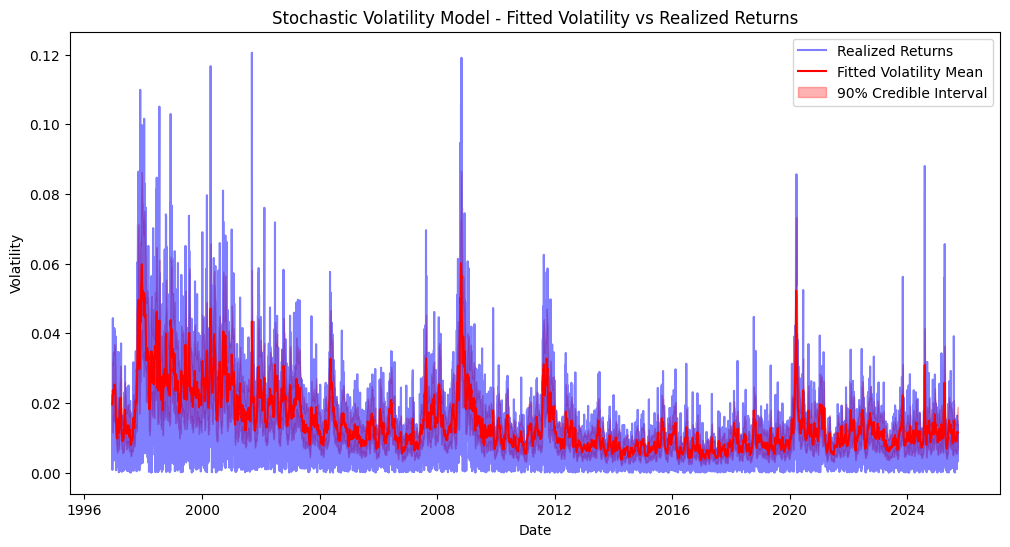

In [28]:
volatility_samples, forecast_return_samples, forecast_volatility_samples=fit_and_predict(returns, forecasts_steps=1, burn_in=1000, n_samples=3000)
realized_returns=abs(returns - returns.mean())
fitted_volatility_mean=np.mean(volatility_samples, axis=0)
fitted_volatility_5=np.percentile(volatility_samples, 5, axis=0)
fitted_volatility_95=np.percentile(volatility_samples, 95, axis=0)

plt.figure(figsize=(12,6))
plt.plot(returns.index, realized_returns, label='Realized Returns', color='blue', alpha=0.5)
plt.plot(returns.index, fitted_volatility_mean, label='Fitted Volatility Mean', color='red')
plt.fill_between(returns.index, fitted_volatility_5, fitted_volatility_95, color='red', alpha=0.3, label='90% Credible Interval')
plt.title('Stochastic Volatility Model - Fitted Volatility vs Realized Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
from joblib import Parallel, delayed

forecast_cnt=252
forecast_ret=pd.DataFrame(index=returns.index[-forecast_cnt:], columns=['return', 'volatility'])

def process_forecast(forecast_index):
    returns_train=returns[:forecast_index]
    volatility_samples, forecast_return_samples, forecast_volatility_samples=fit_and_predict(returns_train, forecasts_steps=1, burn_in=2000, n_samples=2000)
    return np.mean(forecast_return_samples, axis=0)[0], np.mean(forecast_volatility_samples, axis=0)[0]

results = Parallel(n_jobs=-1)(delayed(process_forecast)(forecast_index) for forecast_index in range(-forecast_cnt-1, -1, 1))
for i, forecast_index in enumerate(range(-forecast_cnt-1, -1, 1)):
    forecast_ret.loc[returns.index[forecast_index+1]]={'return': results[i][0], 'volatility': results[i][1]}

MCMC Sampling: 100%|██████████| 4000/4000 [00:08<00:00, 485.85it/s]


In [19]:
print(forecast_ret)

              return volatility
2025-07-11  -0.00011   0.013084
2025-07-14  0.000344   0.013992
2025-07-15  0.000285   0.012362
2025-07-16  0.000088    0.01184
2025-07-17 -0.000421   0.010889
2025-07-18 -0.000161   0.011019
2025-07-21 -0.000252   0.009632
2025-07-22  0.000375   0.008734
2025-07-23 -0.000152   0.009058
2025-07-24  0.000094   0.010338
2025-07-25 -0.000116   0.009503
2025-07-28  0.000096   0.008899
2025-07-29 -0.000212   0.007764
2025-07-30  0.000385   0.007642
2025-07-31 -0.000054   0.007729
2025-08-01 -0.000022   0.007981
2025-08-04   0.00006     0.0076
2025-08-05 -0.000127   0.016547
2025-08-06 -0.000426   0.015634
2025-08-07  0.000769   0.015956
2025-08-08  0.000094   0.014443
2025-08-11  0.000239   0.013377
2025-08-12 -0.000728   0.012459
2025-08-13 -0.000235   0.010983
2025-08-14   0.00009    0.01041
2025-08-18 -0.000411   0.010671
2025-08-19  0.000109   0.009714
2025-08-20  0.000218   0.011422
2025-08-21  0.000147   0.011447
2025-08-22  0.000185   0.011139
2025-08-

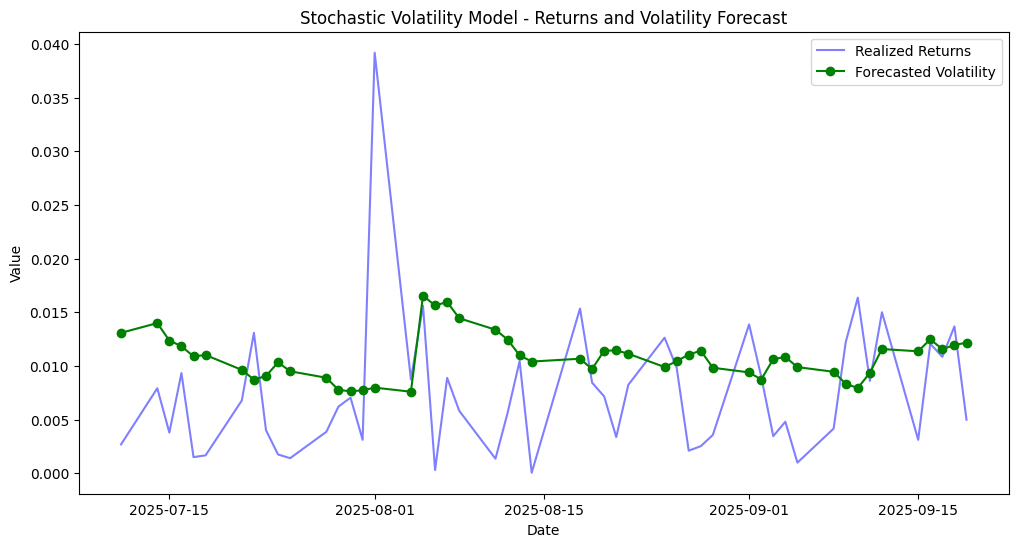

In [ ]:

train_return_mean=returns[:-forecast_cnt].mean()
realized_returns=abs(returns[-forecast_cnt:] - train_return_mean)
plt.figure(figsize=(12,6))
plt.plot(returns.index[-forecast_cnt:], realized_returns, label='Realized Returns', color='blue', alpha=0.5)
plt.plot(forecast_ret.index, forecast_ret['volatility'], label='Forecasted Volatility', color='green', marker='o')
plt.title('Stochastic Volatility Model - Returns and Volatility Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
from arch import arch_model
import numpy as np
import pandas as pd

r_full = returns - returns.iloc[:-forecast_cnt].mean()

# ----- 0) 데이터 정리 -----
test_idx = returns.index[-forecast_cnt:]
train_returns = returns.iloc[:-forecast_cnt] - returns.iloc[:-forecast_cnt].mean()
test_returns  = returns.loc[test_idx] - returns.iloc[:-forecast_cnt].mean()

r_real = test_returns.to_numpy(dtype=np.float64)
eps = 1e-12


garch_sig_roll = []

for t in tqdm(range(forecast_cnt)):
    train_slice = r_full.iloc[:-(forecast_cnt - t)]
    train_slice = train_slice - train_slice.mean()
    model = arch_model(train_slice, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=1)
    sig_t = np.sqrt(forecast.variance.values[-1, 0])
    garch_sig_roll.append(sig_t)

garch_sig = np.array(garch_sig_roll)

# ----- 3) 평가 지표 -----
def eval_metrics(r_real: np.ndarray, sig_hat: np.ndarray) -> dict:
    sig2 = np.maximum(sig_hat**2, eps)
    QLIKE   = np.mean((r_real**2) / sig2 + np.log(sig2))
    MSE_vol = np.mean((np.abs(r_real) - sig_hat)**2)
    z=r_real / np.maximum(sig_hat, np.sqrt(eps))
    z_mean=np.mean(z)
    z_var=np.var(z)
    corr_abs=np.corrcoef(np.abs(r_real), sig_hat)[0,1]
    return {"QLIKE": float(QLIKE), "MSE_vol": float(MSE_vol), "z_mean": float(z_mean), "z_var": float(z_var), "corr_abs": float(corr_abs)}

# ----- 1) N일 롤링 변동성 벤치마크 생성 -----
def rolling_sigma_benchmark(returns_centered: pd.Series, N: int, test_idx: pd.Index) -> np.ndarray:
    """
    t 시점의 예측에 과거 N일( t-1, ..., t-N )의 제곱 평균을 사용.
    sigma_hat_t = sqrt( mean( r_{t-1}^2, ..., r_{t-N}^2 ) )
    """
    r2_ma = returns_centered.pow(2).rolling(N).mean()  # 각 시점까지 과거 N일 평균
    # t 시점 예측은 t-1까지 정보만 사용해야 하니 한 칸 쉬프트
    sig = np.sqrt(np.maximum(r2_ma.shift(1).loc[test_idx].to_numpy(dtype=np.float64), eps))
    return sig


N_list = [5, 10, 20, 60, 252]  # 필요하면 자유롭게 수정

bench_sig = {f"N{N}": rolling_sigma_benchmark(r_full, N, test_idx) for N in N_list}

# SV 모델 결과 (이미 계산한 forecast_ret 사용)
sv_sig = forecast_ret.loc[test_idx, 'volatility'].to_numpy(dtype=np.float64)
res_sv = eval_metrics(r_real, sv_sig)

# 롤링 벤치마크 결과 (앞서 만든 bench_sig 사용)
res_bench = {name: eval_metrics(r_real, sig) for name, sig in bench_sig.items()}

# GARCH 결과
res_garch = eval_metrics(r_real, garch_sig)

# ----- 4) 표로 정리 -----
results_all = {**res_bench, "SV": res_sv, "GARCH(1,1)": res_garch}
res_df = pd.DataFrame(results_all).T.sort_values("QLIKE")
print(res_df)


100%|██████████| 50/50 [00:00<00:00, 106.55it/s]

               QLIKE   MSE_vol    z_mean     z_var  corr_abs
N60        -8.188790  0.000053  0.121317  0.842075 -0.096134
N252       -8.102525  0.000073  0.108253  0.559799 -0.085963
GARCH(1,1) -8.085335  0.000060  0.107621  0.887614 -0.131141
N20        -8.080633  0.000054  0.155583  1.062205 -0.166066
SV         -7.961322  0.000061  0.108692  1.117703 -0.166883
N10        -7.649208  0.000058  0.132066  1.663927 -0.144909
N5         -7.017539  0.000064  0.066836  2.471227 -0.100942
